In [1]:
from functools import partial 
from collections import defaultdict 
import numpy as np # Numerical computing library
import matplotlib.pyplot as plt # Plotting library
import scipy.integrate #Integration library
from mpl_toolkits.mplot3d import axes3d #Used for the 3d bifurcation plot
import matplotlib.patches as mpatches #used to write custom legends
from datetime import datetime

%matplotlib inline

from scipy.stats import kde
from scipy.integrate import odeint
from scipy.optimize import fsolve 
from scipy.optimize import minimize
from scipy.optimize import curve_fit
from scipy.optimize import basinhopping
from scipy.optimize import Bounds

from pymcmcstat.MCMC import MCMC
from pymcmcstat.plotting import MCMCPlotting
from pymcmcstat.ParallelMCMC import ParallelMCMC
from pymcmcstat.chain import ChainProcessing as CP
from pymcmcstat.chain import ChainStatistics as CS
from pymcmcstat import mcmcplot as mcp

import numpy as np # Numerical computing library
import matplotlib.pyplot as plt # Plotting library
import scipy.integrate #Integration library
import matplotlib.patches as mpatches #used to write custom legends
import math
import os
import sys
import glob
import matplotlib
import numpy as np
import pandas as pd
import xlrd
import matplotlib as mpl
import scipy.io as sio
import pymcmcstat
import scipy
import seaborn as sns
import statistics
import scipy.stats as st
import pymc3
import matplotlib.pyplot as plt

In [2]:
def ODE_system(rho,mu,eta,v,t):   
    y=np.zeros((6))
    alpha = 0.2     # incubation period 5 days
    beta = 0.85     # average contact rate [beta = R0*gamma; R0 = 2.5 (Hellewell, 2020)]
    gamma = 0.34    # mean infectious period = 2.9 (Kucharski,2020)
    tau=68
    chi=0
    if (t<tau): 
        rho0=1
        mu0=0
        chi0=0
        eta0=0
        y[0]=-rho0*beta*v[0]*v[2]-mu0*v[0]
        y[1]=rho0*beta*v[0]*v[2] - alpha*v[1] - chi0*0.33*v[1]#E
        y[2]=alpha*v[1] - gamma*v[2] - eta*v[2]#I
        y[3]=mu0*v[0]#P
        y[4]=chi0*0.33*v[1] + eta*v[2]#Q
        y[5]=gamma*v[2]#R
    if ((t>=tau) and (t<tau+7)):
        mu0=mu
        chi0=0
        eta0=0
        rho0=1
        y[0]=-rho0*beta*v[0]*v[2]-mu0*v[0]
        y[1]=rho0*beta*v[0]*v[2] - alpha*v[1] - chi0*0.33*v[1]#E
        y[2]=alpha*v[1] - gamma*v[2] - eta*v[2]#I
        y[3]=mu0*v[0]#P
        y[4]=chi0*0.33*v[1] + eta*v[2]#Q
        y[5]=gamma*v[2]#R
    if (t>=tau+7):
        rho0= rho
        chi0 = chi
        eta0= eta
        mu0= 0  
        y[0]=-rho0*beta*v[0]*v[2]-mu0*v[0]
        y[1]=rho0*beta*v[0]*v[2] - alpha*v[1] - chi0*0.33*v[1]#E
        y[2]=alpha*v[1] - gamma*v[2] - eta*v[2]#I
        y[3]=mu0*v[0]#P
        y[4]=chi0*0.33*v[1] + eta*v[2]#Q
        y[5]=gamma*v[2]#R
    return y

In [3]:
def ODE_system1(v,t):   
    y=np.zeros((6))
    alpha = 0.2     # incubation period 5 days
    beta = 0.85     # average contact rate [beta = R0*gamma; R0 = 2.5 (Hellewell, 2020)]
    gamma = 0.34    # mean infectious period = 2.9 (Kucharski,2020)
    tau=68
    rho=0.26
    mu=0
    chi=0
    eta=0
    if (t<tau): 
        rho0=1
        mu0=0
        chi0=0
        eta0=0
        y[0]=-rho0*beta*v[0]*v[2]-mu0*v[0]
        y[1]=rho0*beta*v[0]*v[2] - alpha*v[1] - chi0*0.33*v[1]#E
        y[2]=alpha*v[1] - gamma*v[2] - eta*v[2]#I
        y[3]=mu0*v[0]#P
        y[4]=chi0*0.33*v[1] + eta*v[2]#Q
        y[5]=gamma*v[2]#R
    if ((t>=tau) and (t<tau+7)):
        mu0=mu
        chi0=0
        eta0=0
        rho0=1
        y[0]=-rho0*beta*v[0]*v[2]-mu0*v[0]
        y[1]=rho0*beta*v[0]*v[2] - alpha*v[1] - chi0*0.33*v[1]#E
        y[2]=alpha*v[1] - gamma*v[2] - eta*v[2]#I
        y[3]=mu0*v[0]#P
        y[4]=chi0*0.33*v[1] + eta*v[2]#Q
        y[5]=gamma*v[2]#R
    if (t>=tau+7):
        rho0= rho
        chi0 = chi
        eta0= eta
        mu0= 0  
        y[0]=-rho0*beta*v[0]*v[2]-mu0*v[0]
        y[1]=rho0*beta*v[0]*v[2] - alpha*v[1] - chi0*0.33*v[1]#E
        y[2]=alpha*v[1] - gamma*v[2] - eta*v[2]#I
        y[3]=mu0*v[0]#P
        y[4]=chi0*0.33*v[1] + eta*v[2]#Q
        y[5]=gamma*v[2]#R
    
    return y

In [4]:
def model_EMT(v,t,ListOfParameters):
    
    #model system
    #S, E, R ,II ,Q, NII, D,H,Hl,ICU, AICU,NI,NI1,R1,D1
    
    
    # This removes the delay, so this parameter is not playing a role anymore
    
   #rho,mu,chi,eta,
    
    rho=ListOfParameters[0] 
    mu=ListOfParameters[1]
    #chi=ListOfParameters[2]
    eta=ListOfParameters[2]
    
    #M=ListOfParameters[8]

    y=ODE_system(rho,mu,eta, v,t)
    
    return y

In [5]:
# HERE WE SHOULD ADD THE LAST RHO CHANGE AND THE APPROPRIATE SECOND WAVE PARAMS< EVEN IF NOT USED< FOR MORE CONSISTENCY

def gpp2_1st(u,t,theta,data):

    y=np.zeros((6))
    v=u
    #rho,mu,chi,eta,
    rho=theta[0]
    mu=theta[1]
    #chi=theta[2]
    eta=theta[2]
    
   
    ListOfParametersfirst=np.array([rho,mu,eta])#M

    
    y=model_EMT(v,t,ListOfParametersfirst)
    return y

In [6]:
# initial conditions
IR_N = 5000000
IR_init_vals = (1-1/IR_N, 1/IR_N, 0, 0, 0 ,0)   #working with fractions of population
IR_active = np.array([[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,2,6,6,18,18,19,21,34,42,42,89,127,127,167,216,285,549,675,777,897,1114,1317,1550,1795,2094,2374,2564,2851,3159,3357,3746,4148,4442,4811,5165,5474,5814,6286,7777,8583,9296,10257,11048,12026,12708,13373,14110,14564,14888,6077,6669,7580,7937,8265,8942,9313,9485,5677,5994,6182,6504,6817,7067,7258,3763,3872,4002,4204,4428,4558,4644,2434,2851,2968,3045,3099,3183,3220,1684,1748,1854,1918,1971,2032,2060,1083,1113,1142,1189,1249,1323,1319,754,780,795,807,824,826,826,838,837,847,892,899,917,927,933,943,956,961,966,968,973,306,314,320,339,340,363,373,375,387,394,404,422,426,432,440]])/IR_N
    
time = np.linspace(0,len(IR_active)-1,len(IR_active))
print(np.size(IR_active))
data1=time
#print(AT_active[65])
print(IR_active[0,:])

162
[0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 2.0000e-07 2.0000e-07 2.0000e-07 4.0000e-07 1.2000e-06
 1.2000e-06 3.6000e-06 3.6000e-06 3.8000e-06 4.2000e-06 6.8000e-06
 8.4000e-06 8.4000e-06 1.7800e-05 2.5400e-05 2.5400e-05 3.3400e-05
 4.3200e-05 5.7000e-05 1.0980e-04 1.3500e-04 1.5540e-04 1.7940e-04
 2.2280e-04 2.6340e-04 3.1000e-04 3.5900e-04 4.1880e-04 4.7480e-04
 5.1280e-04 5.7020e-04 6.3180e-04 6.7140e-04 7.4920e-04 8.2960e-04
 8.8840e-04 9.6220e-04 1.0330e-03 1.0948e-03 1.1628e-03 1.2572e-03
 1.5554e-03 1.7166e-03 1.8592e-03 2.0514e-03 2.2096e-03 2.4052e-03
 2.5416e-03 2.6746e-03 2.8220e-03 2.9128e-03 2.9776e-03 1.2154e-03
 1.3338e-03 1.5160e-03 1.5874e-03 1.6530e-03 1.7884e-03 1.

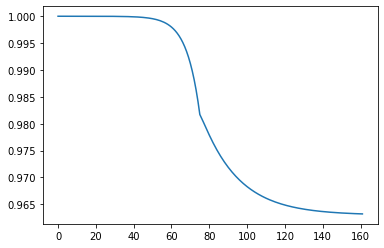

In [7]:
#ODE_system(0.3,0.001,0.001,0.001,AT_init_vals,time)
#ODE_system(0.3,0.001,0.001,0.001,AT_init_vals,time)
#time = np.linspace(0,len(AT_active)-1,len(AT_active))
IR_init_vals = (1-1/IR_N, 1/IR_N, 0, 0, 0 ,0)   #working with fractions of population

tt=162
t2=np.linspace(0,tt-1,tt)
resultsseir2=odeint(ODE_system1,IR_init_vals,t2)
plt.plot(t2,resultsseir2[:,0] )

In [8]:
def errorxy1(theta,data):
    #AT_init_vals = (1 - 1/AT_N, 1/AT_N, 0, 0, 0 ,0)    #working with fractions of population
    #AT_init_vals = (AT_N-1, 1, 0, 0, 0 ,0)    #working with fractions of population
    IR_init_vals = (1 - 1/IR_N, 1/IR_N, 0, 0, 0 ,0 )   #working with 


    RMS=np.zeros(0)
    tt=162
    t2=np.linspace(0,tt-1,tt)
    #time = np.linspace(0,len(AT_active)-1,len(AT_active))
    #t2=np.linspace(0,tt-1,tt)
    
    y=IR_active
   
    resultsseir2=odeint(gpp2_1st,IR_init_vals,t2,args=(theta,IR_active))
    cc=0
    cci=0
    
    for i in range (0,162):
        cc=(resultsseir2[i,2]-IR_active[0,i])**2+cci
        cci=(cc)
    
    RMS=cc
            
    return RMS

In [79]:
### FIRST WE CREATE SETUP FOR ONE CHAIN AS WE WERE DOING BEFORE ###

# initialize MCMC object
MyNew_mcstat = MCMC(rngseed=123456789)

# initialize data structure 
MyNew_mcstat.data.add_data_set(x=data1,y=IR_active)
#rho,mu,chi,eta
# Set Boundaries of Parameter Space
MyNew_mcstat.parameters.add_model_parameter(name='rho', minimum=0.1, maximum=0.4)
MyNew_mcstat.parameters.add_model_parameter(name='mu', minimum=0.001, maximum=0.12)
#MyNew_mcstat.parameters.add_model_parameter(name='chi', minimum=0.001, maximum=0.7)
MyNew_mcstat.parameters.add_model_parameter(name='eta', minimum=0.001, maximum=0.1)

# Define options
datestr = datetime.now().strftime('%Y%m%d_%H%M%S')
savedir = 'Saved_MCMC_Chains' + os.sep + str('{}_{}'.format(datestr,'parallel_chains'))
#nsimu=int(500e3)
MyNew_mcstat.simulation_options.define_simulation_options(nsimu=int(50e3), updatesigma=True, method='dram',
                                                         savedir=savedir, savesize=10000, save_to_json=True,
                                                          save_lightly=True, save_to_bin=True)
MyNew_mcstat.model_settings.define_model_settings(sos_function=errorxy1)



In [80]:
My_Parallel_MCMC = ParallelMCMC()
My_Parallel_MCMC.setup_parallel_simulation(MyNew_mcstat, initial_values=None, num_cores=8, num_chain=8)

In [81]:
# DO NOT RE-RUN THIS UNLESS YOU WISH A NEW MCMC CHAIN (CAN TAKE 8 HOURS WITH 500000 ITERATIONS)
My_Parallel_MCMC.run_parallel_simulation()

Processing: Saved_MCMC_Chains/20210312_142142_parallel_chains/chain_0
Processing: Saved_MCMC_Chains/20210312_142142_parallel_chains/chain_2
Processing: Saved_MCMC_Chains/20210312_142142_parallel_chains/chain_3
Processing: Saved_MCMC_Chains/20210312_142142_parallel_chains/chain_1

Sampling these parameters:
Sampling these parameters:
Sampling these parameters:
Sampling these parameters:



      name      start [      min,       max] N(       mu,   sigma^2)
      name      start [      min,       max] N(       mu,   sigma^2)
      name      start [      min,       max] N(       mu,   sigma^2)
      name      start [      min,       max] N(       mu,   sigma^2)
       rho:      0.29 [     0.10,      0.40] N( 0.00e+00,      inf)
       rho:      0.37 [     0.10,      0.40] N( 0.00e+00,      inf)
       rho:      0.31 [     0.10,      0.40] N( 0.00e+00,      inf)
       rho:      0.26 [     0.10,      0.40] N( 0.00e+00,      inf)
        mu:      0.02 [ 1.00e-03,      0.12] N( 0.00e+00,   

In [82]:
My_Parallel_MCMC.display_individual_chain_statistics()


****************************************
Displaying results for chain 0
Files: Saved_MCMC_Chains/20210312_142142_parallel_chains/chain_0


------------------------------
name      :       mean        std     MC_err        tau     geweke
rho       :     0.2521     0.0864     0.0013    12.2728     0.9785
mu        :     0.0565     0.0342     0.0004    12.8452     0.9314
eta       :     0.0422     0.0293     0.0004    13.2065     0.9893
------------------------------
Acceptance rate information
---------------
Results dictionary:
Stage 1: 26.95%
Stage 2: 48.25%
Net    : 75.20% -> 37600/50000
---------------
Chain provided:
Net    : 75.20% -> 37600/50000
---------------
Note, the net acceptance rate from the results dictionary
may be different if you only provided a subset of the chain,
e.g., removed the first part for burnin-in.
------------------------------

****************************************
Displaying results for chain 1
Files: Saved_MCMC_Chains/20210312_142142_parallel_chains/

In [9]:
# Loading saved MCMC Chains
DirectoryOfPreviousRunMCMC = 'Saved_MCMC_Chains/20210312_142142_parallel_chains'#20201121_123636_parallel_chains_1stWave'#20201113_233605_parallel_chains' #'Saved_MCMC_Chains/20201113_201228_parallel_chains_1stWave'
# FRA: 20201113_232939_parallel_chains' # 8 chains, 500k each, narrower p par space
pres = CP.load_parallel_simulation_results(DirectoryOfPreviousRunMCMC)
combined_chains, index = CP.generate_combined_chain_with_index(pres)
np.shape(combined_chains) # 8 chains x 500k/2 = 2 Millions points

(200000, 3)

In [10]:
### RUN DIAGNOStiC TO ASSESS IN A QUANTITATIVE MANNER IF THE MULTIPLE EMCMC CHAINS CONVERGED ###

# Gelman-Rubin Diagnostic (https://github.com/prmiles/pymcmcstat_examples/blob/master/Running_Parallel_Chains.ipynb)

chains = CP.generate_chain_list(pres)
psrf = CS.gelman_rubin(chains=chains, display=True)

# In general, R closer to 1 indicates your chains have converged.

Parameter: $p_{0}$
  R = 1.0002903989166503
  B = 0.10197539859868114
  W = 0.007390924070408343
  V = 0.007395217326382467
  neff = 14503.92433470343
Parameter: $p_{1}$
  R = 1.0001736617604633
  B = 0.010089610726036861
  W = 0.0011721393313024213
  V = 0.0011725464782118408
  neff = 23242.65048573207
Parameter: $p_{2}$
  R = 1.0002236160328808
  B = 0.009252090270100235
  W = 0.0008544210589300113
  V = 0.0008548032261498086
  neff = 18478.05633527499


In [11]:
print(np.shape(chains))

## Prepare indexes to cut chains, only 1 point every 100

### CHANGE THE ABOVE WHEN YOU RUN A LONGER CHAIN!!! ###

if np.shape(chains)[1] <= 10000:
    OneStepEveryNinChains = 1
elif np.shape(chains)[1] > 10000 and np.shape(chains)[1] <= 100000:
    OneStepEveryNinChains = 10
elif np.shape(chains)[1] >= 100000:
    OneStepEveryNinChains = 100

Indexes1OutOf100 = np.arange(0,np.shape(chains)[1],OneStepEveryNinChains) # np.arange(0,500,1) # np.linspace(0,250000,2501)[0:-1]
Indexes1OutOf100 = Indexes1OutOf100.astype(int)
print(np.shape(chains[0][Indexes1OutOf100,:]))
#print(np.shape(chains[0][:,:]))

# NO, FOR PLOTTING TOO LONG. Based on the paper from Link and Eaton (2012), we decide instead to keep all points of the chain

# Cut chains and concatenate them
MyChain = chains[0][Indexes1OutOf100,:]
#MyChain = chains[0][:,:]
#MyChain_BurninRemoved = MyChain[100::,:]
MyChain_BurninRemoved = MyChain[:,:]

ConcatenatedExtractedChains = MyChain_BurninRemoved
print(np.shape(ConcatenatedExtractedChains))
for i in range(7):
    # Take out first 10000 of each chain i.e. 100 of the points left) for burnin
    MyChain = chains[i+1][Indexes1OutOf100,:]
    #MyChain = chains[i+1][:,:]
    #MyChain_BurninRemoved = MyChain[100::,:]
    MyChain_BurninRemoved = MyChain[:,:]

    # Than concatenate
    ConcatenatedExtractedChains = np.concatenate((ConcatenatedExtractedChains,MyChain_BurninRemoved),axis=0)
print(np.shape(ConcatenatedExtractedChains))





(8, 25000, 3)
(2500, 3)
(2500, 3)
(20000, 3)


In [12]:
Chains = ConcatenatedExtractedChains
# GET THE MEAN A POSTERIORI ESTIMATE OF THE PARAM ALPHA_E
MeanEstimate_rho = statistics.mean(Chains[:,0])
print(MeanEstimate_rho)

0.25519536751979993


In [13]:
Chains = ConcatenatedExtractedChains
# GET THE MEAN A POSTERIORI ESTIMATE OF THE PARAM ALPHA_M
MeanEstimate_mu = statistics.mean(Chains[:,1])
print(MeanEstimate_mu)

0.057268872425675174


In [14]:
# GET THE MEAN A POSTERIORI ESTIMATE OF THE PARAM DELTA_E
MeanEstimate_chi = statistics.mean(Chains[:,2])
print(MeanEstimate_chi)

0.0418884057256965


In [15]:
# GET THE MEAN A POSTERIORI ESTIMATE OF THE PARAM DELTA_M
MeanEstimate_eta = statistics.mean(Chains[:,3])
print(MeanEstimate_eta)

IndexError: index 3 is out of bounds for axis 1 with size 3

0.33605004128067195


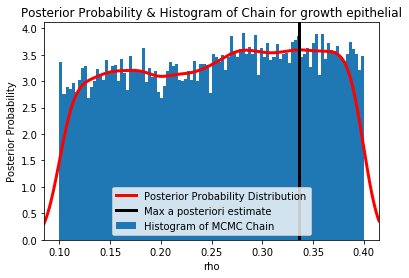

In [16]:
plt.hist(Chains[:,0], density=True, bins=100, label="Histogram of MCMC Chain")
mn, mx = plt.xlim()
plt.xlim(mn, mx)
kde_xs = np.linspace(mn, mx, 1000)
kde = st.gaussian_kde(Chains[:,0])
plt.plot(kde_xs,kde.pdf(kde_xs),label="Posterior Probability Distribution",linewidth=3,color='red')
plt.ylabel('Posterior Probability')
plt.xlabel('rho')#Names[i])
plt.title("Posterior Probability & Histogram of Chain for growth epithelial")# + str(Names[i]));
posterior=list(kde.pdf(kde_xs))
a=posterior.index(max(posterior))
plt.axvline(x=kde_xs[a],linewidth=3,color='black',label='Max a posteriori estimate')
plt.legend(loc="best")

MaxEstimate_rho = kde_xs[a]
print(MaxEstimate_rho)

0.019424459448287322


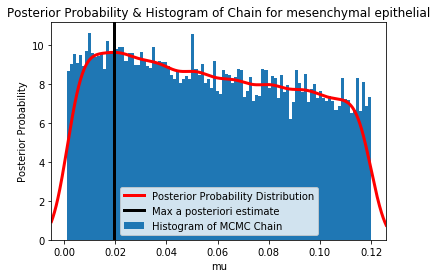

In [17]:
plt.hist(Chains[:,1], density=True, bins=100, label="Histogram of MCMC Chain")
mn, mx = plt.xlim()
plt.xlim(mn, mx)
kde_xs = np.linspace(mn, mx, 1000)
kde = st.gaussian_kde(Chains[:,1])
plt.plot(kde_xs,kde.pdf(kde_xs),label="Posterior Probability Distribution",linewidth=3,color='red')
plt.ylabel('Posterior Probability')
plt.xlabel('mu')#Names[i])
plt.title("Posterior Probability & Histogram of Chain for mesenchymal epithelial")# + str(Names[i]));
posterior=list(kde.pdf(kde_xs))
a=posterior.index(max(posterior))
plt.axvline(x=kde_xs[a],linewidth=3,color='black',label='Max a posteriori estimate')
plt.legend(loc="best")

MaxEstimate_mu = kde_xs[a]
print(MaxEstimate_mu)

0.008694990724652145


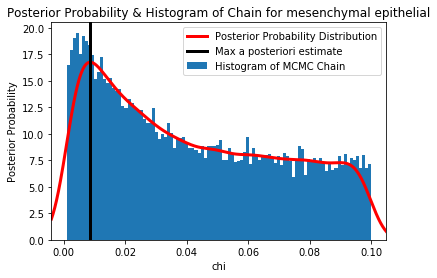

In [18]:
plt.hist(Chains[:,2], density=True, bins=100, label="Histogram of MCMC Chain")
mn, mx = plt.xlim()
plt.xlim(mn, mx)
kde_xs = np.linspace(mn, mx, 1000)
kde = st.gaussian_kde(Chains[:,2])
plt.plot(kde_xs,kde.pdf(kde_xs),label="Posterior Probability Distribution",linewidth=3,color='red')
plt.ylabel('Posterior Probability')
plt.xlabel('chi')#Names[i])
plt.title("Posterior Probability & Histogram of Chain for mesenchymal epithelial")# + str(Names[i]));
posterior=list(kde.pdf(kde_xs))
a=posterior.index(max(posterior))
plt.axvline(x=kde_xs[a],linewidth=3,color='black',label='Max a posteriori estimate')
plt.legend(loc="best")

MaxEstimate_chi = kde_xs[a]
print(MaxEstimate_chi)

In [19]:
plt.hist(Chains[:,3], density=True, bins=100, label="Histogram of MCMC Chain")
mn, mx = plt.xlim()
plt.xlim(mn, mx)
kde_xs = np.linspace(mn, mx, 1000)
kde = st.gaussian_kde(Chains[:,3])
plt.plot(kde_xs,kde.pdf(kde_xs),label="Posterior Probability Distribution",linewidth=3,color='red')
plt.ylabel('Posterior Probability')
plt.xlabel('eta')#Names[i])
plt.title("Posterior Probability & Histogram of Chain for mesenchymal epithelial")# + str(Names[i]));
posterior=list(kde.pdf(kde_xs))
a=posterior.index(max(posterior))
plt.axvline(x=kde_xs[a],linewidth=3,color='black',label='Max a posteriori estimate')
plt.legend(loc="best")

MaxEstimate_eta = kde_xs[a]
print(MaxEstimate_eta)

IndexError: index 3 is out of bounds for axis 1 with size 3

<Figure size 640x480 with 0 Axes>

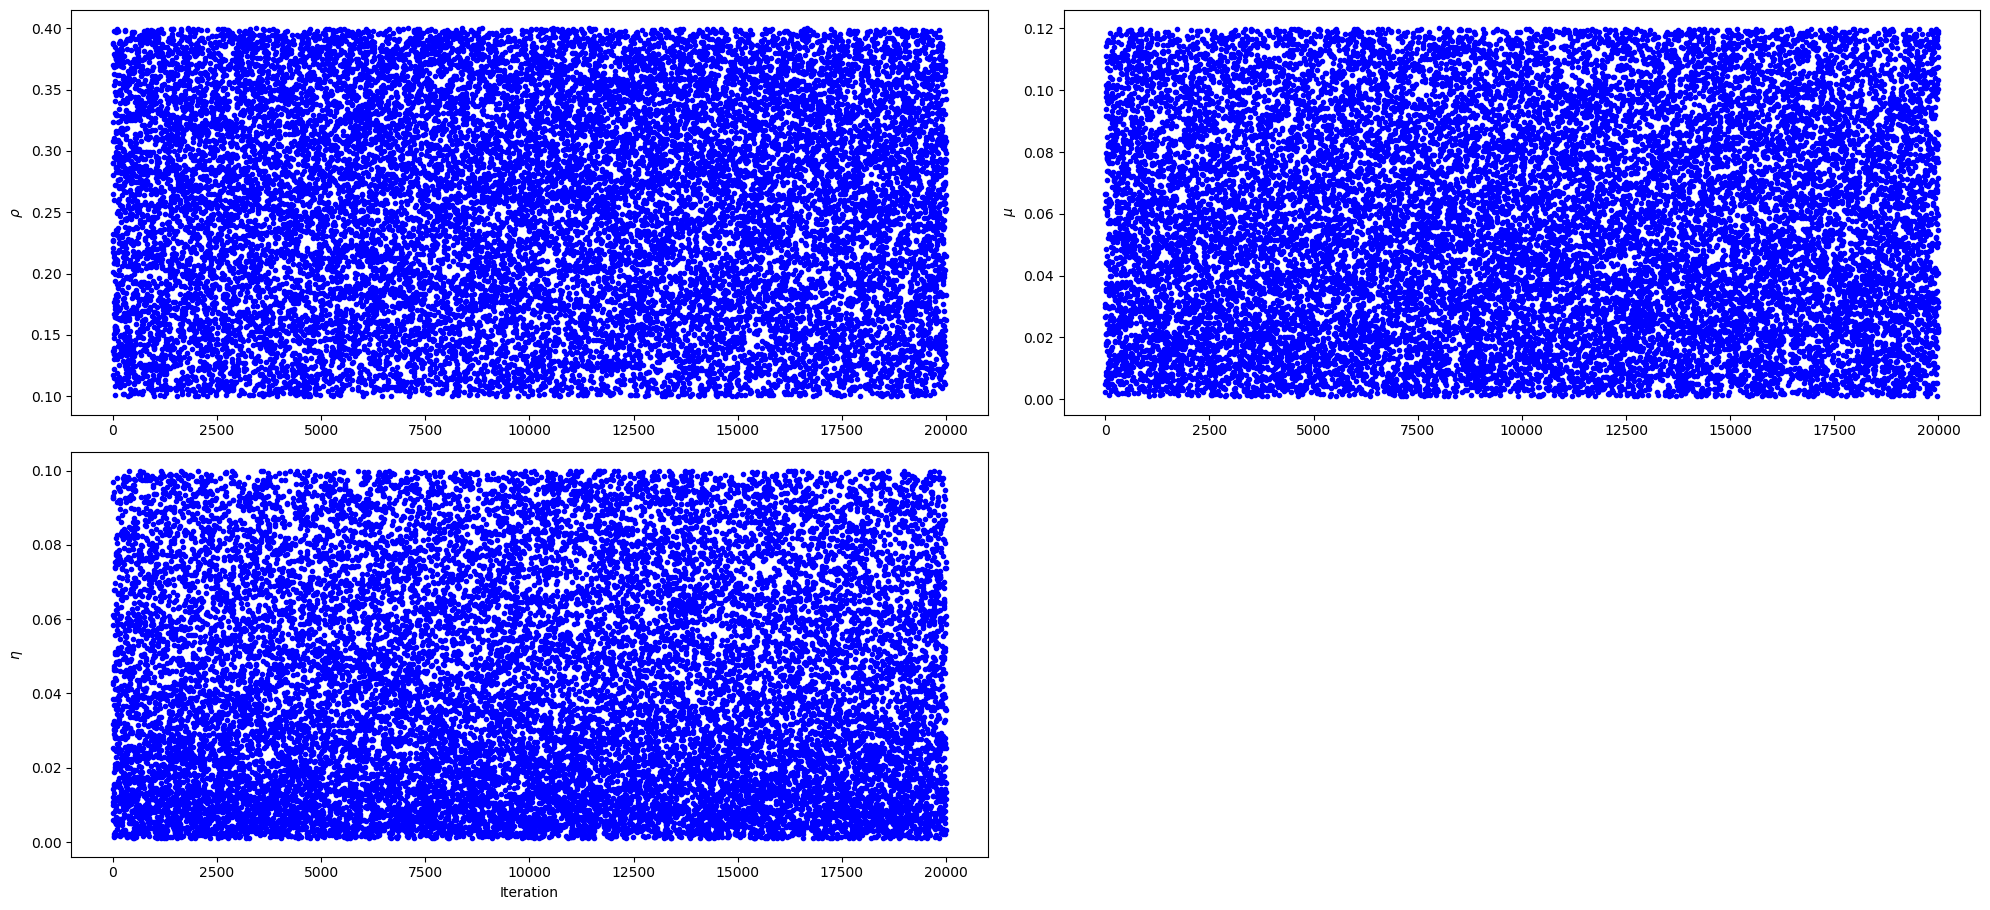

In [15]:
plt.style.use('default') # 'ggplot' Other styles at https://matplotlib.org/3.1.1/gallery/style_sheets/style_sheets_reference.html
plt.figure(facecolor="white")
settings = dict(
    fig=dict(figsize=(20, 10))
)
# Later make this authomatic!!!
NamesParamsParallelChains = [r'$\rho$',r'$\mu$',r'$\eta$']

mcp.plot_chain_panel(ConcatenatedExtractedChains,NamesParamsParallelChains, settings,maxpoints=1000000)
plt.savefig('./Results/Parallel8CutChains_EMT.eps')
# One can save the figure directly on computer as a pdf (or any other format), just uncomment the following
# pdf quality is better, but reduce the number of points in plot (maxpoints above) 
# otherwise too heavy and slow to visualize!!!
# plt.savefig('./Results/MCMC_2ndWave/Chains_1D_2ndWave_2ndWave.pdf')

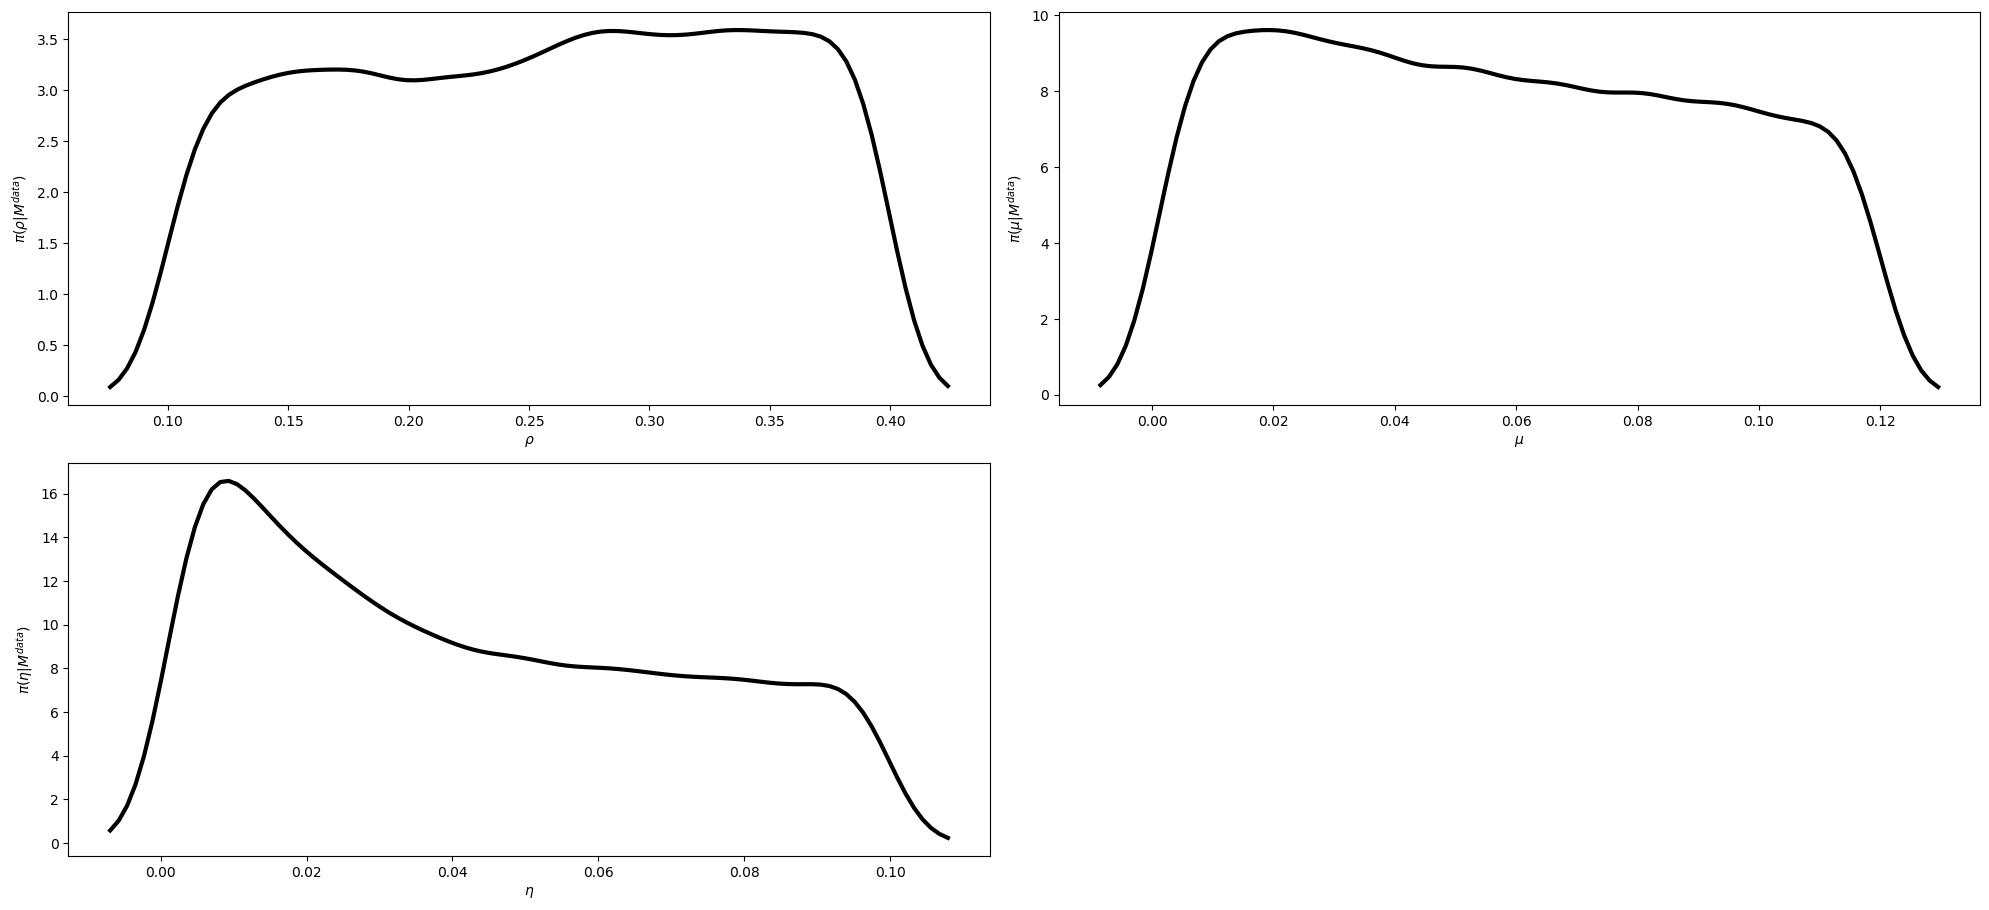

In [16]:
mcp.plot_density_panel(ConcatenatedExtractedChains,NamesParamsParallelChains, settings)
plt.savefig('./Results/Parallel8CutChains_Posteriors.eps')

In [17]:
# We here need to define once and for all the function to make the nice colorful plot 
# of 2D posterior densities for all paramerters with blue and red colormap

# IF TOO SLOW, REDUCE THE NUMBER OF BINS, nbins = 20 IS ENOUGH AND GOES FASTER
# IF YOU WANT MORE RESOLUTION (NOT NEEDED), INCREASE THE NUMBER OF BINS, e.g. nbins = 50, NEGLIGIBLE IMPROVEMENT BUT SLOWER

def PlotDensityPosteriorWithContours(axes,My_chain,i,j): # ,MyNLevels):
    
    from scipy.stats import kde

    nbins = 30 # This can be changed to make more smooth or more granular densities
    # Evaluate a gaussian kde on a regular grid of nbins x nbins over data extents
    data = My_chain[:,[j,i]]
    x, y = data.T
    k = kde.gaussian_kde(data.T)
    xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
    zi = k(np.vstack([xi.flatten(), yi.flatten()]))
    # Added to make Credible Intervals
    zi_Norm=zi/sum(zi)
    # Order zis
    zi_Norm_Sorted_Reverted = sorted(zi_Norm, reverse=True)
    # sum them up in decreasing order
    IntegralOverPosterior = 0
    CounterContours = 0
    for ThisZi in zi_Norm_Sorted_Reverted:
        IntegralOverPosterior = IntegralOverPosterior + ThisZi
        if CounterContours == 0 and IntegralOverPosterior >= 0.25: # 25%
            ContourValue25 = ThisZi
            CounterContours = 1
        elif CounterContours == 1 and IntegralOverPosterior >= 0.5: # 50%
            ContourValue50 = ThisZi
            CounterContours = 2
        elif CounterContours == 2 and IntegralOverPosterior >= 0.90: # 90%
            ContourValue90 = ThisZi
            CounterContours = 3
    
    im = axes[i,j].pcolormesh(xi, yi, zi_Norm.reshape(xi.shape), shading='gouraud', cmap='coolwarm')
    im = axes[i,j].contour(xi, yi, zi_Norm.reshape(xi.shape), colors='k',levels=[ContourValue90,ContourValue50,ContourValue25]) # MyNLevels
 
    
def Plot_Multiple_2D_Densities(My_chain,My_names,FileNameForSaving):
    
    MyMarkersSize = 40#20#16

    NumberOfParameters = len(My_names)
        
    plt.style.use('default') # 'ggplot' Other styles at https://matplotlib.org/3.1.1/gallery/style_sheets/style_sheets_reference.html
    plt.figure(facecolor="white")
    
    fig, axes = plt.subplots(nrows=NumberOfParameters, ncols=NumberOfParameters, subplot_kw=dict(facecolor='white'))
    
    for ax in axes.flat:
        # Hide all ticks and labels
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        # Set up ticks only on one side for the "edge" subplots...
        if ax.is_first_col():
            ax.yaxis.set_ticks_position('left')
        if ax.is_last_col():
            ax.yaxis.set_ticks_position('right')
            ax.yaxis.set_label_position('right')
        if ax.is_first_row():
            ax.xaxis.set_ticks_position('top')
            ax.xaxis.set_label_position('top')
        if ax.is_last_row():
            ax.xaxis.set_ticks_position('bottom')
    
    ListOfParametersNamesForLegend = My_names
    # NLevels = 3 # Number of (black) Contour Lines in each plot
    
    for i in range(NumberOfParameters):
        for j in range(NumberOfParameters):
            DotSize = 1#14
            if i>j:
                if (i % 2) != 0:
                    if (j % 2) != 0:
                        # im = axes[i,j].scatter(My_chain[:,j], My_chain[:,i])#, s=DotSize, c='b', edgecolor = '')#, cmap=plt.cm.rainbow_r)
                        PlotDensityPosteriorWithContours(axes,My_chain,i,j)#,NLevels)
                elif (i % 2) == 0:
                    if  (j % 2) == 0:
                        PlotDensityPosteriorWithContours(axes,My_chain,i,j)#,NLevels)
            elif i<j:
                if (i % 2) != 0:
                    if (j % 2) == 0:
                        PlotDensityPosteriorWithContours(axes,My_chain,i,j)#,NLevels)
                elif (i % 2) == 0:
                    if (j % 2) != 0:
                        PlotDensityPosteriorWithContours(axes,My_chain,i,j)#,NLevels)
            elif i==j:
                # Label the diagonal subplots...
                axes[i,j].annotate(ListOfParametersNamesForLegend[i].split(" ", 1)[0], (0.5, 0.5), xycoords='axes fraction', ha='center', va='center',size=MyMarkersSize)
                #axes[i,j].scatter(ListOfOutputArrays[2+i], ListOfOutputArrays[0], s=8)               
    
            axes[i,j].set_xlim(min(My_chain[:,j]),max(My_chain[:,j]))
            axes[i,j].set_ylim(min(My_chain[:,i]),max(My_chain[:,i]))
            plt.setp(axes[i,j].get_xticklabels(), rotation=45, horizontalalignment='left')

    #cbar = fig.colorbar(im,ax=axes.ravel().tolist())
    #cbar.set_label('Marginal Posterior Probability')
    
    for k in range(round(NumberOfParameters/2)):
    
        axes[NumberOfParameters-1,2*k].xaxis.set_visible(True)
        axes[NumberOfParameters-1,2*k].locator_params(axis='x',nbins=5)
        plt.setp(axes[NumberOfParameters-1,2*k].get_xticklabels(), rotation=45, horizontalalignment='right')
        axes[NumberOfParameters-1,2*k].set_xlabel(ListOfParametersNamesForLegend[2*k],size=MyMarkersSize)
        axes[NumberOfParameters-1,2*k].get_xaxis().set_tick_params(direction='out')
    
        axes[2*k,0].yaxis.set_visible(True)
        axes[2*k,0].locator_params(axis='y',nbins=5)
        axes[2*k,0].set_ylabel(ListOfParametersNamesForLegend[2*k],size=MyMarkersSize)
        axes[2*k,0].get_yaxis().set_tick_params(direction='out')

    Remaining = NumberOfParameters % 2 
    
    if Remaining > 0: # then NumberOfParameters was an odd number
        
        for k in range(round(NumberOfParameters/2)-1):

            axes[0,2*k+1].xaxis.set_visible(True)
            axes[0,2*k+1].locator_params(axis='x',nbins=5)
            plt.setp(axes[0,2*k+1].get_xticklabels(), rotation=45, horizontalalignment='left')
            axes[0,2*k+1].set_xlabel(ListOfParametersNamesForLegend[2*k+1],size=MyMarkersSize)
            axes[0,2*k+1].get_xaxis().set_tick_params(direction='out')

            axes[2*k+1,NumberOfParameters-1].yaxis.set_visible(True)
            axes[2*k+1,NumberOfParameters-1].locator_params(axis='y',nbins=5)
            axes[2*k+1,NumberOfParameters-1].set_ylabel(ListOfParametersNamesForLegend[2*k+1],size=MyMarkersSize)
            axes[2*k+1,NumberOfParameters-1].get_yaxis().set_tick_params(direction='out')

    elif Remaining == 0: # then NumberOfParameters was an odd number

        for k in range(round(NumberOfParameters/2)):

            axes[0,2*k+1].xaxis.set_visible(True)
            axes[0,2*k+1].locator_params(axis='x',nbins=5)
            plt.setp(axes[0,2*k+1].get_xticklabels(), rotation=45, horizontalalignment='left')
            axes[0,2*k+1].set_xlabel(ListOfParametersNamesForLegend[2*k+1],size=MyMarkersSize)
            axes[0,2*k+1].get_xaxis().set_tick_params(direction='out')

            axes[2*k+1,NumberOfParameters-1].yaxis.set_visible(True)
            axes[2*k+1,NumberOfParameters-1].locator_params(axis='y',nbins=5)
            axes[2*k+1,NumberOfParameters-1].set_ylabel(ListOfParametersNamesForLegend[2*k+1],size=MyMarkersSize)
            axes[2*k+1,NumberOfParameters-1].get_yaxis().set_tick_params(direction='out')
    
    fig.set_figheight(25)
    fig.set_figwidth(25)
    plt.subplots_adjust(wspace=0, hspace=0)
               
    fig.savefig(FileNameForSaving)

    plt.show()
    

<Figure size 640x480 with 0 Axes>

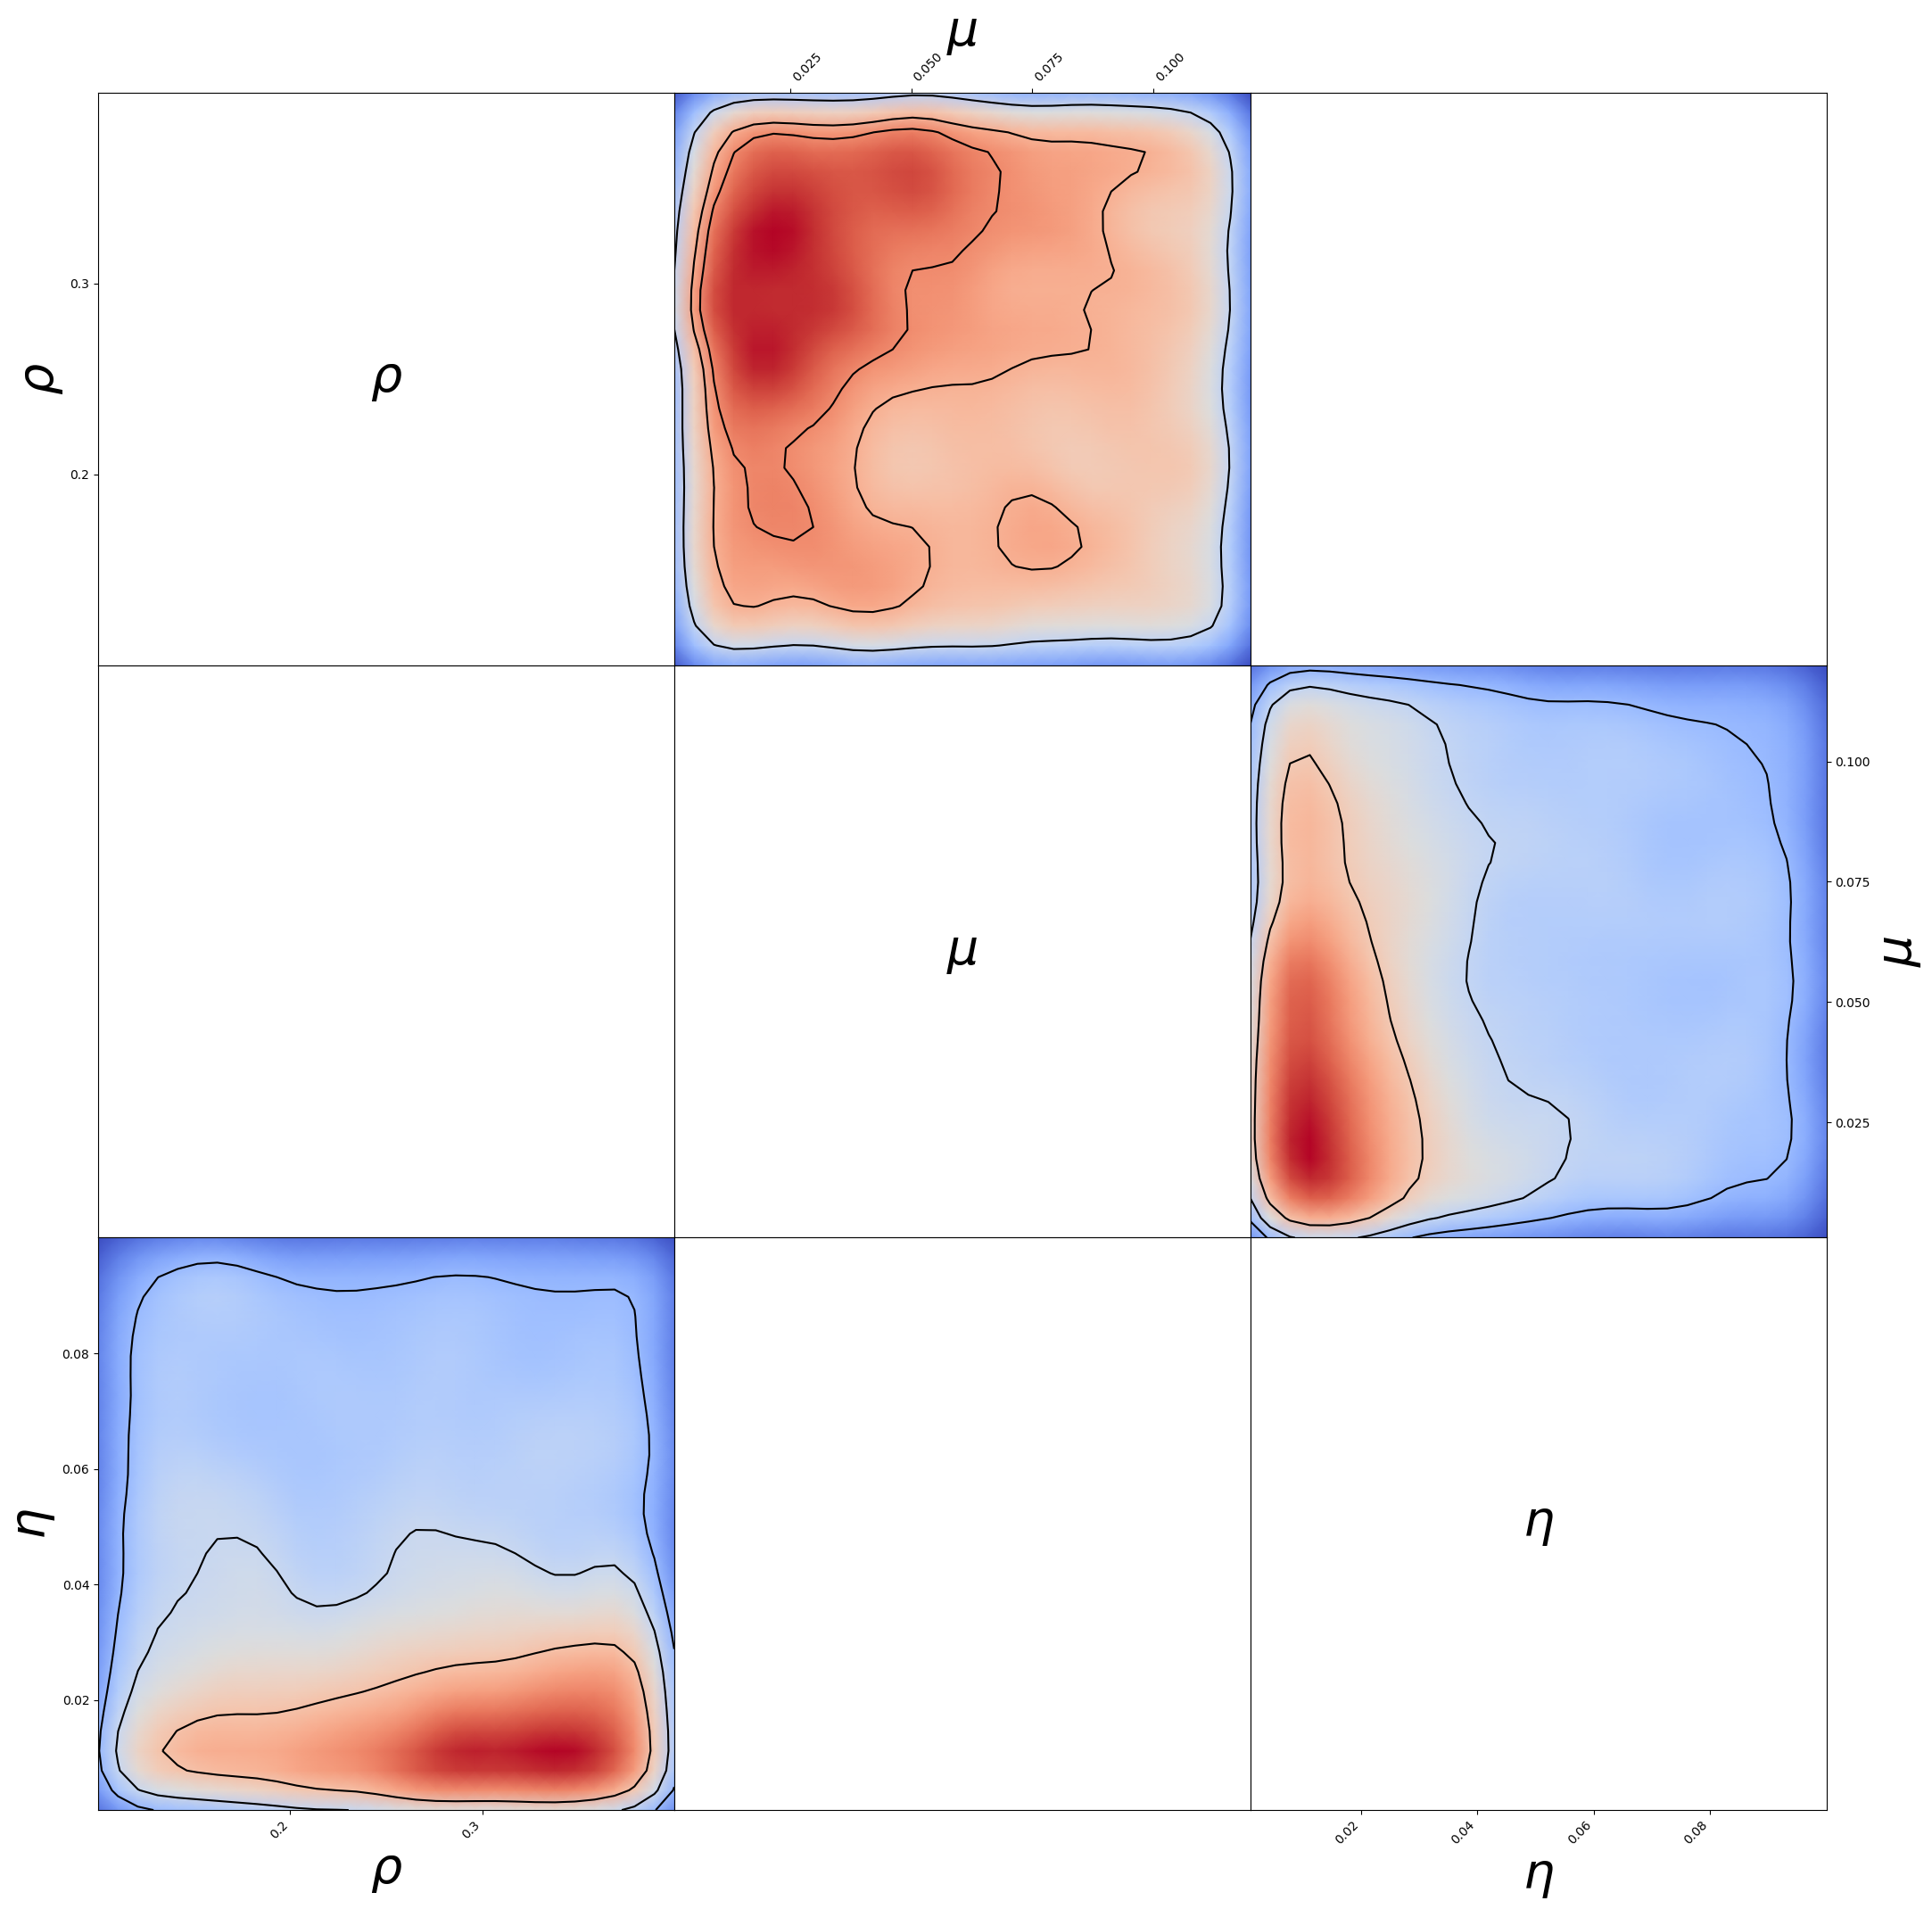

In [19]:
Plot_Multiple_2D_Densities(ConcatenatedExtractedChains, NamesParamsParallelChains, 
                           FileNameForSaving='./Results/Parallel8CutChains_Posteriors_2D_Ireland.eps')

In [24]:
# SO LET'S PLOT ONLY A SUBSET OF THESE MULTIPLE CHAINS

if np.shape(chains)[1] <= 10000:
    OneStepEveryNinChains = 1
elif np.shape(chains)[1] > 10000 and np.shape(chains)[1] <= 100000:
    OneStepEveryNinChains = 10
elif np.shape(chains)[1] >= 100000:
    OneStepEveryNinChains = 100
    
Indexes1OutOf100_For2000000 = np.arange(0,8*np.shape(chains)[1],OneStepEveryNinChains) # np.arange(0,4000,1) # np.linspace(0,2000000,20001)[0:-1]
Indexes1OutOf100_For2000000 = Indexes1OutOf100_For2000000.astype(int)

combined_chains_CUT = combined_chains[Indexes1OutOf100_For2000000,:]
index = np.array(index)
index_CUT = index[Indexes1OutOf100_For2000000]

plt.savefig('./Results/ParallelChainsDensityPlots.eps')

<Figure size 640x480 with 0 Axes>

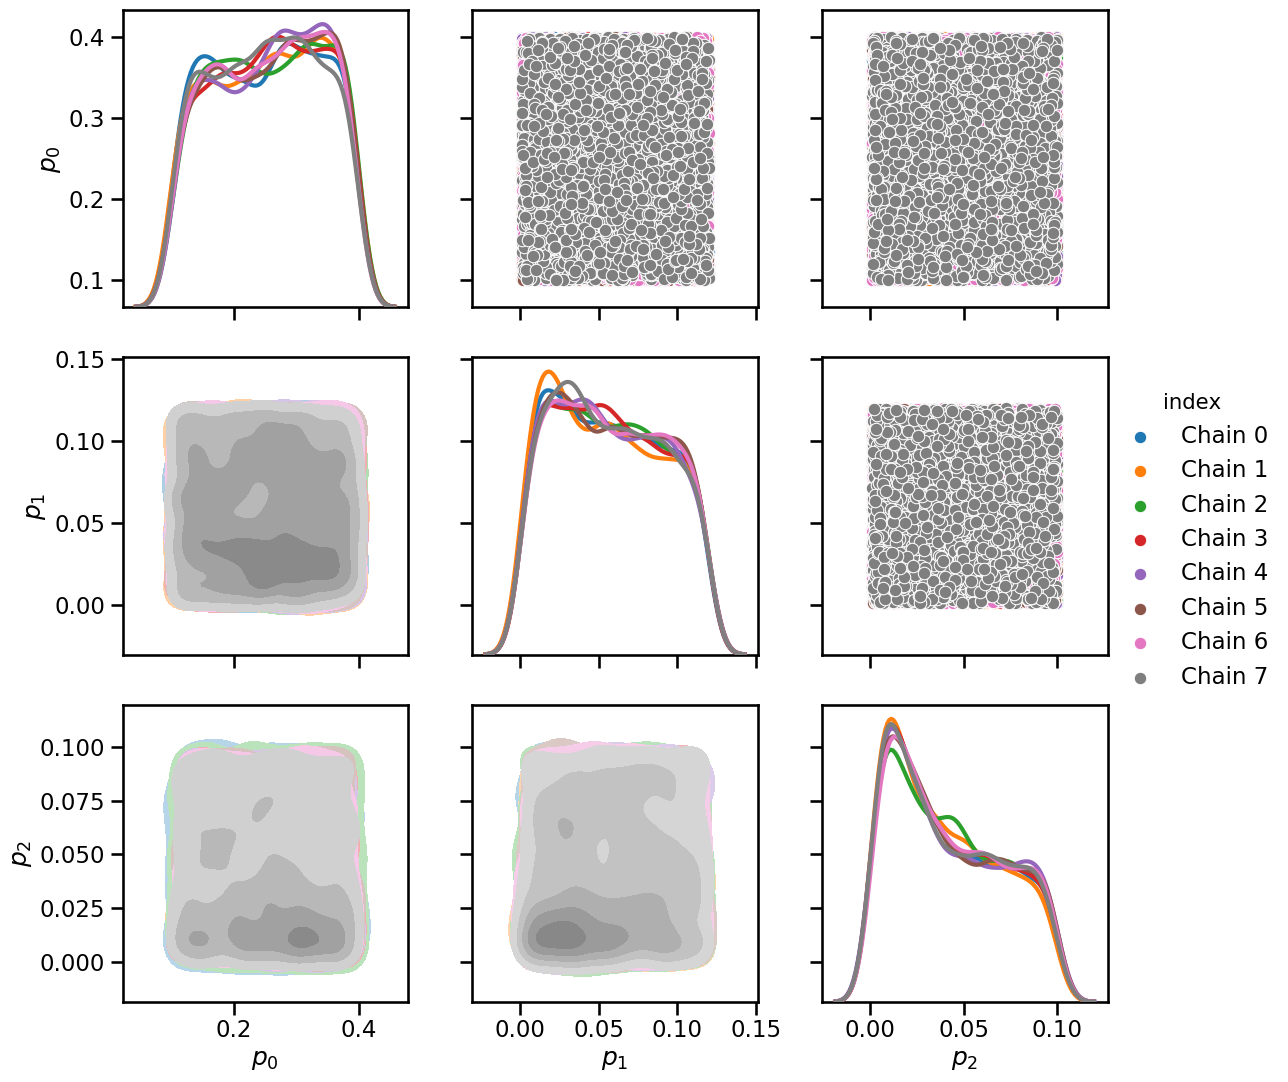

In [25]:
# VERY COOL, BUT CAN TAKE LONG TO RUN...!!!
# PLOT ONLY IF YOU CAN WAIT ONE HOUR!!!

# Please remember that this is an inbuilt function from pymcmcstat so no need to define anything above

settings = dict(
    pairgrid=dict(height=3.75, hue='index', despine=False),
    ld_type=sns.kdeplot,
    ld=dict(n_levels=5, shade=True, shade_lowest=False),
    md=dict(lw=3))
sns.set_context('talk')
fpg = mcp.plot_paired_density_matrix(
    chains=combined_chains_CUT,
    settings=settings,
    index=index_CUT)
tmp = fpg.add_legend()
plt.savefig('./Results/ParallelChainsDensityPlotscombined.eps')

# Trajectories

In [ ]:
# Exercise: 
# - Simulate this system using scipy.integrate.odeint
# - Draw the trajectories using matplotlib.pyplot.plot

# We will look at those set of parameters
scenarios = [{'alpha':1, 'beta':2}, 
             {'alpha':1, 'beta':10}]

# On this timespan
time = np.linspace(0, 20, 1000)

# Here is a list of interesting initial conditions:
initial_conditions = [(.1,1), (2,2),(1,1.3),(2,3),(2,1),(1,2)]

In [ ]:
def cellular_switch(y,t,alpha, beta):
    """ ODE system modeling Gardner's bistable cellular switch
    Args:
        y (array): (concentration of u, concentration of v)
        t (float): Time
        alpha (float): maximum rate of repressor synthesis 
        beta (float): degree of cooperative behavior.
    Return: dy/dt
    """
    u, v = y # you can use y[0], y[1] instead. 
    return np.array([(alpha/(1+v**beta)) - u ,
                     (alpha/(1+u**beta)) - v])

In [ ]:
# Do the simulations.
# Remember that we define f as the partial application of cellular_switch. 
trajectory = {}
for i,param in enumerate(scenarios):
    for j,ic in enumerate(initial_conditions):
        trajectory[i,j] = scipy.integrate.odeint(partial(cellular_switch, **param),
                                                 y0=ic,
                                                 t=time)

In [ ]:
# Draw the trajectories. 
fig, ax = plt.subplots(2,2,figsize=(20,10))
for i,param in enumerate(scenarios):
    for j,ic in enumerate(initial_conditions):
        ax[i][0].set(xlabel='Time', ylabel='Concentration of u', title='Trajectory of u, {}'.format(param))
        ax[i][1].set(xlabel='Time', ylabel='Concentration of v', title='Trajectory of v, {}'.format(param))
        l = ax[i][0].plot(time,trajectory[i,j][:,0], label=ic)
        ax[i][1].plot(time,trajectory[i,j][:,1], color=l[0].get_color())
    ax[i][0].legend(title='Initial conditions')


Isoclines

In [ ]:
uspace = np.linspace(0,2,100)
vspace = np.linspace(0,2,100)

In [ ]:
def plot_isocline(ax, uspace, vspace, alpha, beta, color='k', style='--', opacity=.5):
    """Plot the isoclines of the symmetric cellular switch system"""
    ax.plot(uspace, alpha/(1+uspace**beta), style, color=color, alpha=opacity)
    ax.plot(alpha/(1+vspace**beta),vspace, style, color=color, alpha=opacity)
    ax.set(xlabel='u',ylabel='v')

In [ ]:
def plot_flow(ax, param, uspace, vspace):
    """Plot the flow of the symmetric cellular switch system"""
    X,Y = np.meshgrid(uspace,vspace)
    a = cellular_switch([X,Y],0,**param)   
    ax.streamplot(X,Y,a[0,:,:], a[1,:,:], color=(0,0,0,.1))
    ax.set(xlim=(uspace.min(),uspace.max()), ylim=(vspace.min(),vspace.max()))


In [ ]:
# Correct code (not shown to students)
def findroot(func, init): 
    """ Find root of equation function(x)=0
    Args:
        - the system (function),
        - the initial values (type list or np.array)

    return: correct equilibrium (type np.array) 
            if the numerical method converge or return nan
    """
    sol, info, convergence, sms = scipy.optimize.fsolve(func, init, full_output=1)
    if convergence == 1:
        return sol
    return np.array([np.nan]*len(init))

In [ ]:
def find_unique_equilibria(flow, starting_points):
    '''Return the list of unique equilibria of a flow 
    starting around starting_points'''
    equilibria = [] 
    roots = [findroot(flow, init) 
             for init in starting_points]
    # Only keep unique equilibria 
    for r in roots:
        if (not any(np.isnan(r)) and
            not any([all(np.isclose(r, x)) for x in equilibria])):
            equilibria.append(r)
    return equilibria

equilibria = {}
for i, param in enumerate(scenarios):
    
    # Find the position of the equilibirum around the endpoint of each trajectory. 
    flow = partial(cellular_switch,t=0, **param)
    starting_points = [trajectory[i,j][-1,:] for j 
                       in range(len(initial_conditions))] 
    equilibria[i] = find_unique_equilibria(flow, starting_points)
    print('{} Equilibrium point(s) for parameters: {}'.format(len(equilibria[i]), param))

In [ ]:
def jacobian_cellular_switch(u,v, alpha, beta):
    """ Jacobian matrix of the ODE system modeling Gardner's bistable cellular switch
    Args:
        u (float): concentration of u, 
        v (float): concentration of v,
        alpha (float): maximum rate of repressor synthesis, 
        beta (float): degree of cooperative behavior.
    Return: np.array 2x2"""
    return - np.array([[1, alpha*beta*v**(beta-1) / (1+v**beta)**2  ],
                       [alpha*beta*u**(beta-1) / (1+u**beta)**2, 1]])

In [ ]:
# Alternatively you can use Sympy (Symbolic python) to compute the derivative:
import sympy 
sympy.init_printing()

# Define variable as symbols for sympy
u, v = sympy.symbols("u, v")
alpha, beta = sympy.symbols("alpha, beta")

# Symbolic expression of the system
dudt = alpha/(1 + v**beta) - u
dvdt = alpha/(1 + u**beta) - v

# Symbolic expression of the matrix
sys = sympy.Matrix([dudt, dvdt])
var = sympy.Matrix([u, v])
jac = sys.jacobian(var)

# You can convert jac to a function:
jacobian_cellular_switch = sympy.lambdify((u, v, alpha, beta), jac, dummify=False)

jac

In [ ]:
def stability(jacobian):
    """ Stability of the equilibrium given its associated 2x2 jacobian matrix. 
    Args:
        jacobian (np.array 2x2): the jacobian matrix at the equilibrium point.
    Return:
        (string) status of equilibrium point 
    """
    determinant = np.linalg.det(jacobian)
    trace = np.matrix.trace(jacobian)
    if np.isclose(trace,0) and np.isclose(determinant,0):
        nature = "Center (Hopf)"
    elif np.isclose(determinant,0):
        nature = "Transcritical (Saddle-Node)"
    elif determinant < 0:
        nature = "Saddle"
    else:
        nature = "Stable" if trace < 0 else "Unstable"
        nature += " focus" if (trace**2 - 4 * determinant) < 0 else " node"
    return nature

In [ ]:
# Find the nature of the equilibria
equilibria_nature = {}
for i, param in enumerate(scenarios):
    print('\nParameters: {}'.format(param))
    equilibria_nature[i] = []
    for (u,v) in equilibria[i]:
        equilibria_nature[i].append(stability(jacobian_cellular_switch(u,v, **param)))
        print("{} in ({} {})".format( equilibria_nature[i][-1], u,v,))

In [ ]:
# This is an utility function you can use to make your own graph prettier. 
EQUILIBRIUM_COLOR = {'Stable node':'C0',
                    'Unstable node':'C1', 
                    'Saddle':'C4',
                    'Stable focus':'C3',
                    'Unstable focus':'C2',
                    'Center (Hopf)':'C5',
                    'Transcritical (Saddle-Node)':'C6'}
def plot_equilibrium(ax, position, nature, legend=True):
    """Draw equilibrium points at position with the color 
       corresponding to their nature"""
    for pos, nat in zip(position,nature):
        ax.scatter(pos[0],pos[1],
                   color= (EQUILIBRIUM_COLOR[nat] 
                           if nat in EQUILIBRIUM_COLOR
                           else 'k'),
                   zorder=100)
        
    if legend:
        # Draw a legend for the equilibrium types that were used.
        labels = list(frozenset(nature))
        ax.legend([mpatches.Patch(color=EQUILIBRIUM_COLOR[n]) for n in labels], labels)

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
for i, param in enumerate(scenarios):
    ax[i].set(xlabel='u', ylabel='v', title="Phase space, {}".format(param))
    plot_flow(ax[i], param, uspace=uspace, vspace=vspace)
    plot_isocline(ax[i], uspace=uspace, vspace=vspace, **param)
    for j in range(len(initial_conditions)):
        ax[i].plot(trajectory[i,j][:,0],trajectory[i,j][:,1], color='C3')
    plot_equilibrium(ax[i], equilibria[i], equilibria_nature[i])